In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import yfinance as yf
from helper_functions import *
from datetime import date, datetime

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['axes.grid'] = False
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
import warnings
warnings.filterwarnings('ignore')
import math

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import yfinance as yf
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from sklearn.metrics import normalized_mutual_info_score
from MCMC.MCMC import MCMC

import eikon as ek
ek.set_app_key('9a249e0411184cf49e553b61a6e76c52d295ec17')

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
#tickers = niftydata()
index = ".BSESN"
constituents = get_constituents(index)
constituents_all = []
for i in range(len(constituents)):
    constituents_all = constituents_all+constituents.iloc[i][0]
tickers = list(set(constituents_all))
tickers = [ticker[:-3] for ticker in tickers ]
#Restricted Stock
tickers.remove('AXBK')

In [4]:
recalibrating_months = 1
top_nassets = 10
training_period = 24 #24/48/96
dates_recalibrating = valid_dates(pd.date_range(start="2009-01-01", end="2024-06-15", freq=f'{recalibrating_months}M'))
data_inp = prepare_portfolio_data(tickers, recalibrating_months)

In [5]:
with open(f'BSE_RecalibPeriod_{int(1)}.pkl', 'rb') as file:
    assets = pickle.load(file)

In [6]:
from helper_functions import get_data
from helper_functions import backtest_live, add_fisher



In [7]:
ticker = "^NSEI"
number_of_optimization_periods = 1
recalib_months = 3
num_strategies = 5
metric = 'outperformance'
temp_og = get_data(ticker, "yfinance")
dates = valid_dates(pd.date_range(start=str(temp_og.iloc[1]['Date'] + timedelta(days=365))[:10],
                                                          end="2024-06-15", freq=f'3M'))

with open(f'TickerResults/{ticker}/SelectedStrategies/{ticker}_OptPeriods_{number_of_optimization_periods}_Selected_Strategies_ss.pkl', 'rb') as file:
    ss_test_imp = pickle.load(file)
with open(f'TickerResults/{ticker}/SelectedStrategies/{ticker}_OptPeriods_{number_of_optimization_periods}_Selected_Strategies_res.pkl', 'rb') as file:
    res_test_imp = pickle.load(file)

res_test = []
ss_test = []
datesb = []
for date_i in range(len(dates) - (int(24 / 3) + 1)):
    if (3 * date_i) % recalib_months == 0:
        datesb.append(dates[date_i + int(24 / 3)])
        ss_test.append(ss_test_imp[date_i])
        res_test.append(res_test_imp[date_i])

datesb.append(date.today()+timedelta(1))

with open(f'TickerResults/{ticker}/weights/Results_Ticker{ticker}_LP{number_of_optimization_periods}_Recal{recalib_months}_NS{num_strategies}_M{metric}.pkl', 'rb') as file:
    weights = pickle.load(file)

inputs = []
for date_i in range(len(datesb)-1):
    inputs.append([date_i, datesb, temp_og, ss_test, res_test, num_strategies, weights[date_i], recalib_months,dates])

try:
    pool = multiprocessing.Pool(processes=7, maxtasksperchild=1)
    results_multi = pool.map(backtest_live, inputs)
finally: # To make sure processes are closed in the end, even if errors happen
    pool.close()
    pool.join()

results_final = pd.DataFrame()
for tt in results_multi:
    results_final = pd.concat([results_final, tt[0]], axis=0)

temp_res = results_final
temp_res['Return'] = np.log(temp_res['Close'] / temp_res['Close'].shift(1))
temp_res['Market_Return'] = temp_res['Return'].expanding().sum()
temp_res['Strategy_Return'] = temp_res['S_Return'].expanding().sum()
temp_res['Portfolio Value'] = ((temp_res['Strategy_Return'] + 1) * 10000)
temp_res.reset_index(inplace=True)
temp_res_nifty = temp_res
temp_res_nifty.columns = ["Date"]+[column+"_nifty" for column in temp_res_nifty.columns if column!='Date']


[*********************100%***********************]  1 of 1 completed


In [8]:
ticker = "GOLDBEES.NS"
number_of_optimization_periods = 2
recalib_months = 6
num_strategies = 1
metric = 'outperformance'
temp_og = get_data(ticker, "yfinance")
dates = valid_dates(pd.date_range(start=str(temp_og.iloc[1]['Date'] + timedelta(days=365))[:10],
                                                          end="2024-06-15", freq=f'3M'))

with open(f'TickerResults/{ticker}/SelectedStrategies/{ticker}_OptPeriods_{number_of_optimization_periods}_Selected_Strategies_ss.pkl', 'rb') as file:
    ss_test_imp = pickle.load(file)
with open(f'TickerResults/{ticker}/SelectedStrategies/{ticker}_OptPeriods_{number_of_optimization_periods}_Selected_Strategies_res.pkl', 'rb') as file:
    res_test_imp = pickle.load(file)

res_test = []
ss_test = []
datesb = []
for date_i in range(len(dates) - (int(24 / 3) + 1)):
    if (3 * date_i) % recalib_months == 0:
        datesb.append(dates[date_i + int(24 / 3)])
        ss_test.append(ss_test_imp[date_i])
        res_test.append(res_test_imp[date_i])

datesb.append(date.today()+timedelta(1))

with open(f'TickerResults/{ticker}/weights/Results_Ticker{ticker}_LP{number_of_optimization_periods}_Recal{recalib_months}_NS{num_strategies}_M{metric}.pkl', 'rb') as file:
    weights = pickle.load(file)

inputs = []
for date_i in range(len(datesb)-1):
    inputs.append([date_i, datesb, temp_og, ss_test, res_test, num_strategies, weights[date_i], recalib_months,dates])

try:
    pool = multiprocessing.Pool(processes=7, maxtasksperchild=1)
    results_multi = pool.map(backtest_live, inputs)
finally: # To make sure processes are closed in the end, even if errors happen
    pool.close()
    pool.join()

results_final = pd.DataFrame()
for tt in results_multi:
    results_final = pd.concat([results_final, tt[0]], axis=0)

temp_res = results_final
temp_res['Return'] = np.log(temp_res['Close'] / temp_res['Close'].shift(1))
temp_res['Market_Return'] = temp_res['Return'].expanding().sum()
temp_res['Strategy_Return'] = temp_res['S_Return'].expanding().sum()
temp_res['Portfolio Value'] = ((temp_res['Strategy_Return'] + 1) * 10000)
temp_res.reset_index(inplace=True)
temp_res_gold = temp_res
temp_res_gold.columns = ["Date"]+ [column+"_gold" for column in temp_res_gold.columns if column!='Date']

[*********************100%***********************]  1 of 1 completed


In [9]:
data_inp_backtest = pd.concat([data_inp.set_index('Date'), temp_res_nifty.set_index('Date'), temp_res_gold.set_index('Date')], axis = 1, join = 'inner').reset_index()

<AxesSubplot:xlabel='Date'>

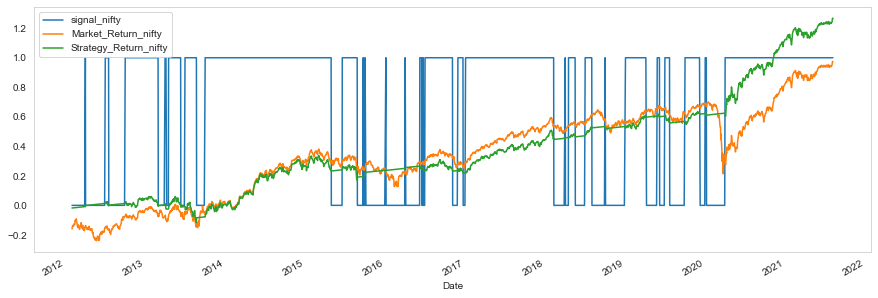

In [10]:
data_inp_backtest[["signal_nifty","Market_Return_nifty", "Strategy_Return_nifty", "Date"]].plot(x="Date")

In [11]:
rebalancing_months = 13
dates_rebalancing = []
assetsb = []
for date_i in range(len(dates_recalibrating)-(int(training_period/recalibrating_months)+1)):
    if ((recalibrating_months*date_i)%rebalancing_months==0) & (dates_recalibrating[date_i + int(training_period/recalibrating_months)]>=data_inp_backtest["Date"][0]):
        dates_rebalancing.append(dates_recalibrating[date_i + int(training_period/recalibrating_months)])
        assetsb.append(assets[date_i])
dates_rebalancing.append(date.today()+timedelta(1))

In [73]:
results_final,unit_ticker, unit_gold = backtest_Alpha_AM(dates_rebalancing, data_inp_backtest, assetsb)

In [74]:
import yfinance as yf
bench = yf.download("^BSESN", start = '2007-01-01', end= str(date.today()))
bench = bench.loc[bench["Close"]>1]
bench["Return"] = np.log(bench["Close"]/bench["Close"].shift(1))

[*********************100%***********************]  1 of 1 completed


In [75]:
# bench = pd.DataFrame()
# bench["Return"] = data_inp[[f"{ticker}Return" for ticker in tickers]].mean(skipna=True, axis=1)
# bench.set_index(data_inp["Date"], inplace=True)
results_final["S_Return"] = pd.DataFrame(np.log(results_final["Pvalue"] / results_final["Pvalue"].shift(1)))
temp_res = pd.concat([results_final,bench["Return"]], join="inner",axis = 1)
temp_res['Market_Return'] = np.exp(temp_res['Return'].expanding().sum())-1
temp_res['Strategy_Return'] = np.exp(temp_res['S_Return'].expanding().sum())-1
temp_res['Portfolio Value'] = ((temp_res['Strategy_Return'] + 1) * 1405000)
temp_res = temp_res.reset_index().rename(columns={'index':"Date"})

In [76]:
temp_res

,Date,Pvalue,S_Return,Return,Market_Return,Strategy_Return,Portfolio Value
0,2012-02-29,1.516361e+06,NaN,0.001215,0.001216,NaN,NaN
1,2012-03-01,1.516722e+06,0.000238,-0.009549,-0.008299,0.000238,1.405335e+06
2,2012-03-02,1.517083e+06,0.000238,0.003000,-0.005319,0.000476,1.405669e+06
3,2012-03-05,1.517444e+06,0.000238,-0.015654,-0.020769,0.000714,1.406004e+06
4,2012-03-06,1.517806e+06,0.000238,-0.010979,-0.031461,0.000953,1.406339e+06
...,...,...,...,...,...,...,...
2258,2021-07-30,9.828891e+06,0.001990,-0.001259,1.761261,5.359757,8.935459e+06
2259,2021-08-02,9.831433e+06,0.000259,0.006894,1.780363,5.361402,8.937770e+06
2260,2021-08-03,9.972410e+06,0.014238,0.016348,1.826189,5.452621,9.065933e+06
2261,2021-08-04,1.000816e+07,0.003578,0.010101,1.854880,5.475750,9.098429e+06


In [ ]:
np.exp(np.log(temp_res.iloc[-1]["Pvalue"]/temp_res.iloc[0]["Pvalue"]))-1

In [ ]:
plt.plot(temp_res['Date'], temp_res['Market_Return'], color='black', label='Market Returns')
plt.plot(temp_res['Date'], temp_res['Strategy_Return'], color='blue', label='Strategy Returns')
plt.title('Strategy Backtest')
plt.legend(loc=0)
plt.tight_layout()
plt.show()

In [ ]:
portfolio = 0
for ticker in unit_ticker.keys():
    price = data_inp_backtest.iloc[-1][ticker]
    units = unit_ticker[ticker]
    portfolio += price*units

In [ ]:
portfolio


In [ ]:
print(f"Sortino: {backtest_sortino(temp_res,0,0)}")
print(f"Sharpe: {backtest_sharpe(temp_res,0,0)}")
print(f"Rolling Sortino: {backtest_rolling_sortino(temp_res,0,0)}")
print(f"Rolling Sharpe: {backtest_rolling_sharpe(temp_res,0,0)}")
print(f"Rolling CAGR: {backtest_rolling_cagr(temp_res,0,0)}")
print(f"Rolling MaxDrawup/MaxDrawdown: {backtest_maxdrawup_by_maxdrawdown(temp_res,0,0)}")
print(f"Rolling Outperformance: {backtest_outperformance(temp_res,0,0)}")

In [ ]:
test = pd.DataFrame()
test1 = get_data("GOLDBEES.NS", "yfinance")
test["yfinance"] = test1[["Close", "Date"]].set_index("Date")

In [ ]:
test2 = get_data("GBES", "investpy")
test["investpy"] = test2[["Close", "Date"]].set_index("Date")

In [ ]:
test.plot()